In [1]:
from sklearn import model_selection, cross_validation, datasets, neighbors, metrics, naive_bayes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
from scipy import stats, optimize
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Метод k ближайщих соседей

In [45]:
size = 1000

In [68]:
X, y = datasets.make_classification(n_samples=size, n_features=2, 
                                    n_informative=2, n_redundant=0,
                                    n_repeated=0, n_classes=4, n_clusters_per_class=1)

Сгенерировали выборку, теперь посмотрим на визуализацию

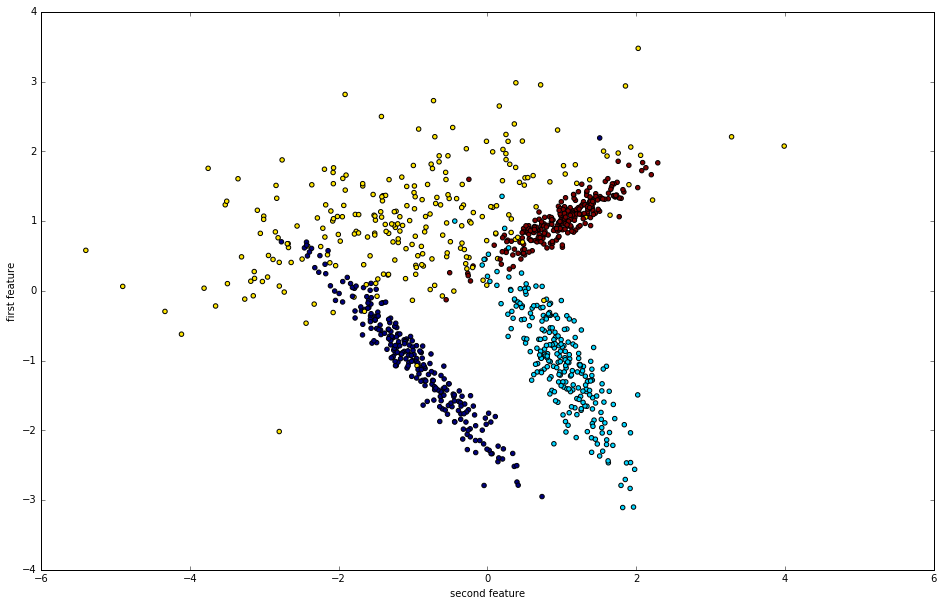

In [69]:
plt.figure(figsize=(16, 10))
plt.scatter(X[:,0], X[:, 1], c = y)
plt.xlabel('second feature')
plt.ylabel('first feature')
plt.show()

Построим разделяющие поверхности для разных k

In [70]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X, 
                                                y, 
                                                test_size = 0.3,
                                                random_state = 1)

In [71]:
ks = np.array([5, 25, 100, 250, 500])

In [72]:
colors = ListedColormap(['red', 'blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])

In [73]:
def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [74]:
def plot_decision_surface(k, train_data, train_labels, test_data, test_labels, 
                          colors = colors, light_colors = light_colors):
    estimator = neighbors.KNeighborsClassifier(n_neighbors=k)
    # возьмём функцию с семинара
    print ('\n\n\nDecision surface for k = ' + str(k))
    
    estimator.fit(train_data, train_labels)
    plt.figure(figsize = (16, 10))
    
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    plt.xlim((train_data[:,0].min(), train_data[:,0].max()))
    plt.ylim((train_data[:,1].min(), train_data[:,1].max()))
    mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, cmap = colors)
    plt.title('Train data, accuracy={:.2f}, k={:d}'.format(metrics.accuracy_score(train_labels,
                                                                             estimator.predict(train_data)), k))
    plt.subplot(1,2,2)
    plt.xlim((train_data[:,0].min(), train_data[:,0].max()))
    plt.ylim((train_data[:,1].min(), train_data[:,1].max()))
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, s = 100, cmap = colors)
    plt.title('Test data, accuracy={:.2f}, k={:d}'.format(metrics.accuracy_score(test_labels,
                                                                           estimator.predict(test_data)), k))
    plt.show()




Decision surface for k = 5


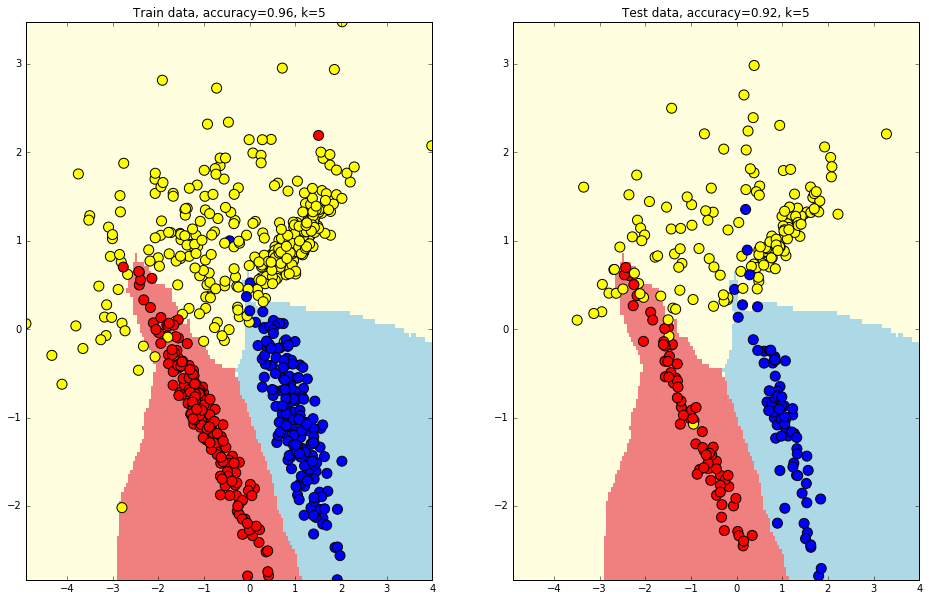




Decision surface for k = 25


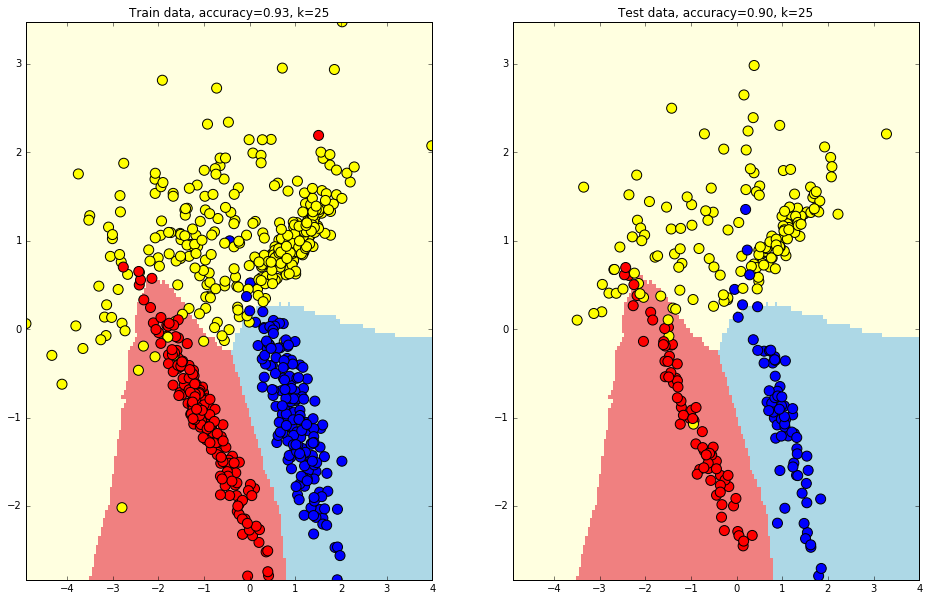




Decision surface for k = 100


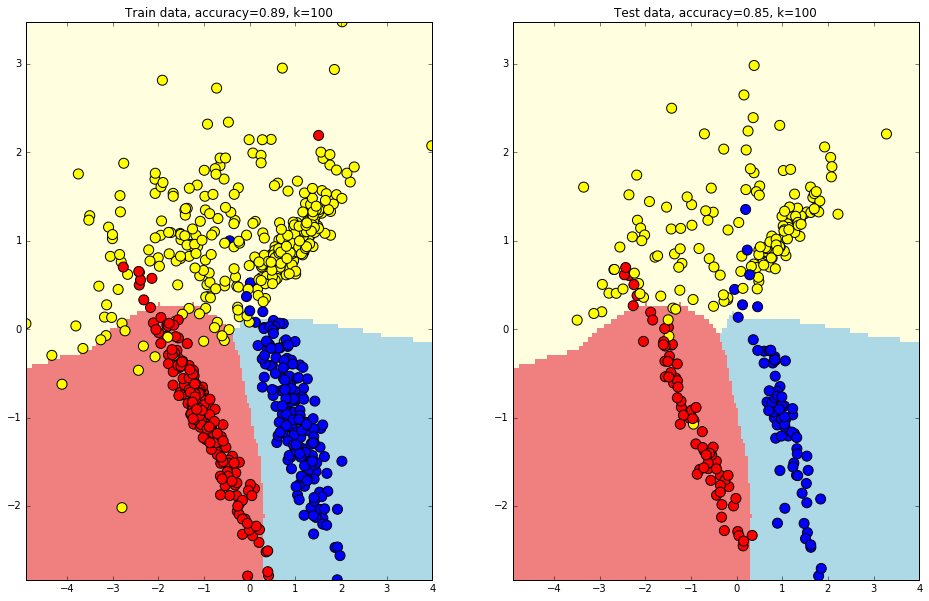




Decision surface for k = 250


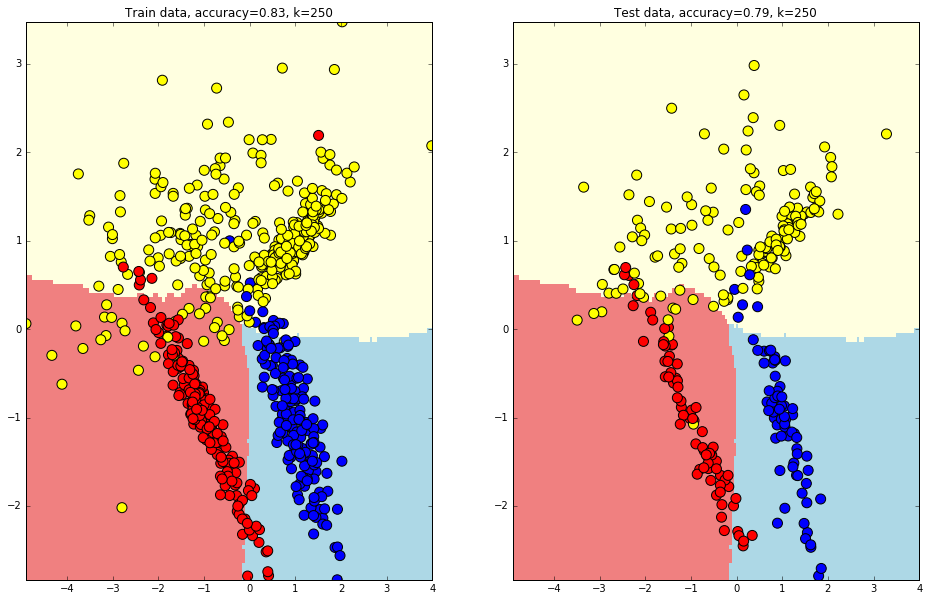




Decision surface for k = 500


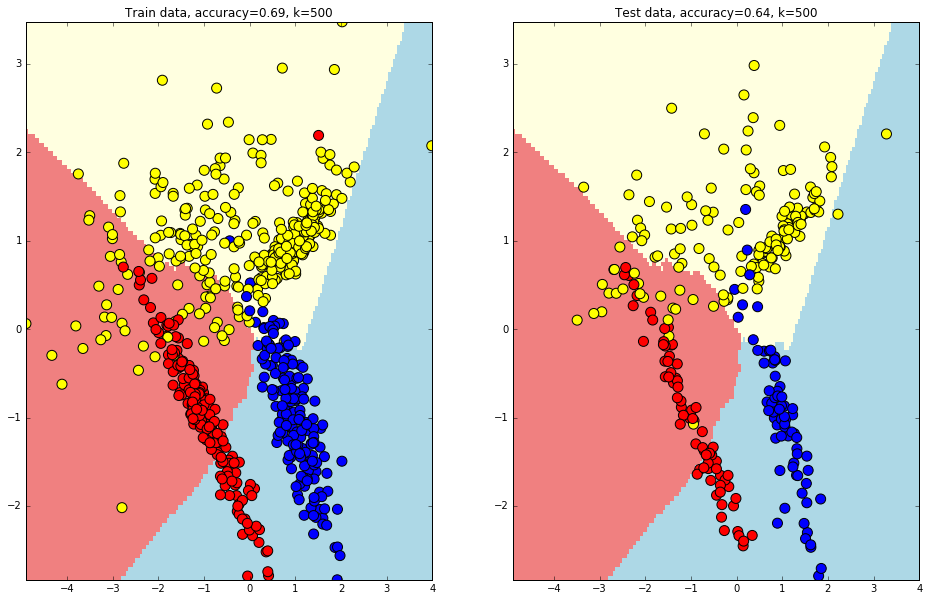

In [75]:
for k in ks:

    plot_decision_surface(k, train_data, train_labels, test_data, test_labels)

Мы можем видеть, что с ростом k разделяющая поверхность для синего класса строится плохо. Оно и понятно, часть его внутри желтого, а с ростом k зависимость от ближайщих экземпляров класса растёт - а т.к. он решает по большинству, а большинство - желтый класс, поэтому он ошибается так. С другой стороны, красный более разрозненный и на тестовой и на обучении, а синий, наоборот, поэтому при больших k разделяющая поверхность у синего становится довольно широкой и поглощает часть точек из других классов.

<br>
<br>
Теперь попробуем подобрать оптимальное $k$ с помощью кросс-валидации.

In [76]:
ks = np.arange(1, 100)

In [77]:
def getAccuracyValidation(k):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
    return (model_selection.cross_val_score(classifier, X, y, cv=5).mean())

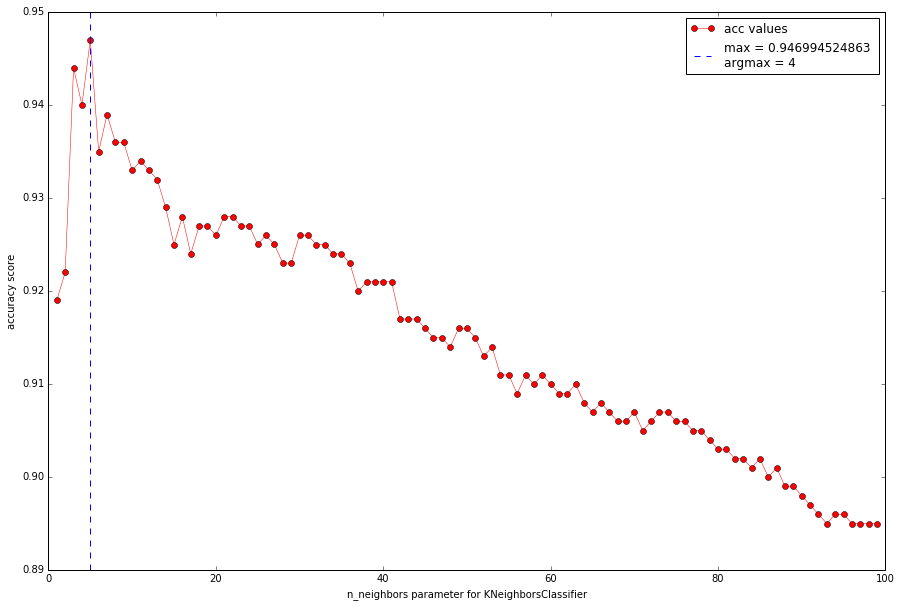

In [78]:
plt.figure(figsize=(15, 10))
plt.xlabel('n_neighbors parameter for KNeighborsClassifier')
plt.ylabel('accuracy score')
acc = np.vectorize(getAccuracyValidation)(ks)
plt.plot(ks, acc, marker='o', lw = 0.5, aa = True, c = 'red')
plt.axvline(np.argmax(acc) + 1, ls = '--')
# + 1 т.к. np.argmax возвращает индекс
plt.legend(['acc values', 'max = ' + str(np.max(acc)) + ' \nargmax = ' + str(np.argmax(acc))])
plt.show()

Получили максимум в точке 4. Сначала accuracy плохое, что обосновывается недостаточностью информации о принадлежности класса, а потом accuracy падает, это уже было обосновано в первом пункте этого задания.

### Наивный байесовский классификатор

In [102]:
digits_data, digits_target = datasets.load_digits(return_X_y=True)
breast_cancer_data, breast_cancer_target = datasets.load_breast_cancer(return_X_y=True)

In [99]:
print (digits.data[0])
print (digits.data[0].shape)


[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]
(64,)


Признаки - целые числа, их довольно много, 64.

In [133]:
print (breast_cancer_data[0])
print (breast_cancer_data[0].shape)

[  1.79900000e+01   1.03800000e+01   1.22800000e+02   1.00100000e+03
   1.18400000e-01   2.77600000e-01   3.00100000e-01   1.47100000e-01
   2.41900000e-01   7.87100000e-02   1.09500000e+00   9.05300000e-01
   8.58900000e+00   1.53400000e+02   6.39900000e-03   4.90400000e-02
   5.37300000e-02   1.58700000e-02   3.00300000e-02   6.19300000e-03
   2.53800000e+01   1.73300000e+01   1.84600000e+02   2.01900000e+03
   1.62200000e-01   6.65600000e-01   7.11900000e-01   2.65400000e-01
   4.60100000e-01   1.18900000e-01]
(30,)


А тут признаки - float.

In [120]:
classifiers = [naive_bayes.BernoulliNB(), naive_bayes.MultinomialNB(), naive_bayes.GaussianNB()]
names = ["BernoulliNB", "MultinomialNB", "GaussianNB"]
digits_acc = [model_selection.cross_val_score(clf, digits_data, digits_target).mean() for clf in classifiers]
bc_acc = [model_selection.cross_val_score(clf, breast_cancer_data,
                                          breast_cancer_target).mean() for clf in classifiers]

In [128]:
print ("digits scores:")
for i in np.arange(len(names)):
    print ("\t{} score is {:.3f}".format(names[i], digits_acc[i]))

digits scores:
	BernoulliNB score is 0.826
	MultinomialNB score is 0.871
	GaussianNB score is 0.819


In [129]:
print ("breast_cancer scores:")
for i in np.arange(len(names)):
    print ("\t{} score is {:.3f}".format(names[i], bc_acc[i]))

breast_cancer scores:
	BernoulliNB score is 0.627
	MultinomialNB score is 0.895
	GaussianNB score is 0.937


Да, как я и ожидал, судя по лекции, когда-то просмотренной на курсере, мультиноминальное хорошо показывает себя на разреженных дискретных (а в digits датасете очень много нулей), при этом он считает, сколько раз какой-то признак появлялся в данных, а в цифрах, которые пишутся очень похоже (там же признаки - это биты в картинке 8х8), это довольно эффективно, поэтому на таком датасете такой классификатор весьма хорош. Бернули ожидаемо плох, т.к. не подсчитывает количество встречаемых признаков, а тут это довольно определяюще.
<br>
<br>
Что касается breast_cancer, то исходно можно было предположить, что гауссовский nb покажет себя хорошо - он же обычно используется, если признаки вещественные, а тут как раз float. Бернулли показывает себя почти как рандом (у которого accuracy примерно 0.5), т.к. на float признаках странно его вообще использовать, т.к. он считает их разными, если они отличаются на очень маленькую величину.

#### Ответы:
1) *Каким получилось максимальное качество классификации на датасете breast_cancer?*<br>
***0.937 у GaussianNB***<br>
2) *Каким получилось максимальное качество классификации на датасете digits?* <br> 
***0.871 у MultinomialNB*** <br>
3) *Какие утверждения верны?* <br>
*(a) На вещественных признаках лучше всего сработал наивный байесовский классификатор с распределением Бернулли* <br>
***False*** <br>
*(b) На вещественных признаках лучше всего сработал наивный байесовский классификатор с мультиномиальным распределением*<br>
***False*** <br>
*(c) Мультиномиальное распределение лучше показало себя на выборке с целыми неотрицательными значениями признаков*<br>
***True*** <br>
*(d) На вещественных признаках лучше всего сработало нормальное распределение*<br>
***True*** <br>

### 3. Метрики в задачах регрессии

In [264]:
eps = stats.norm(loc=0, scale=(0.2) ** 0.5).rvs(size=500)

In [265]:
x = stats.uniform(loc=-50, scale = 100).rvs(size=500)

In [266]:
y = 0.5 * x + 1 + eps

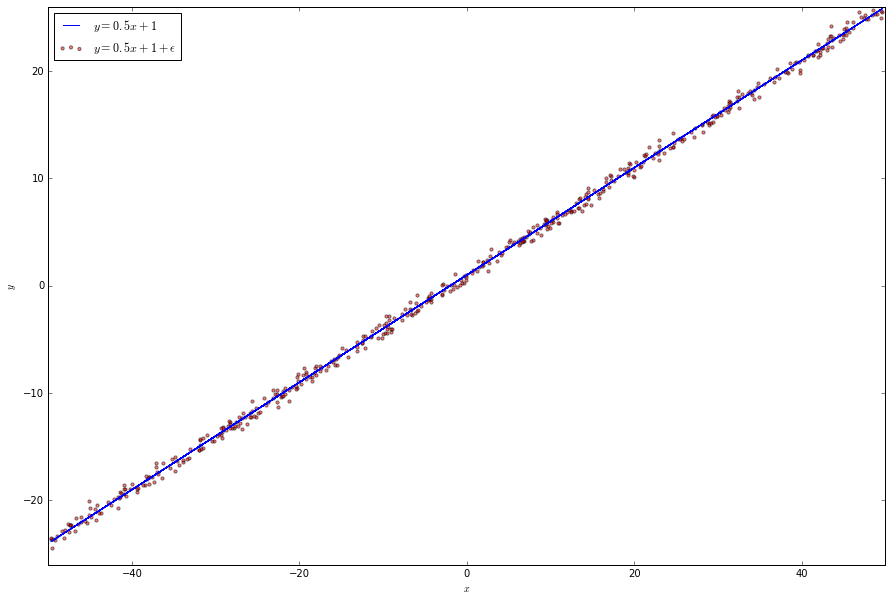

In [267]:
plt.figure(figsize=(15, 10))
plt.xlim((-50, 50))
plt.ylim((-26,26))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, 0.5 * x + 1)
plt.scatter(x, y, s=10, c='r', alpha=0.5)
plt.legend(["$y = 0.5 x + 1$", "$y = 0.5 x + 1 + \epsilon$"], loc='best')
plt.show()

In [268]:
def MSE(coefs):
    return 1.0 / y.shape[0] * np.sum(np.square(y - (coefs[0] * x + coefs[1])))

In [269]:
def MAE(coefs):
    return 1.0 / y.shape[0] * np.sum(np.abs(y - (coefs[0] * x + coefs[1])))

Восстановим зависимость

In [270]:
k, b = optimize.minimize(MSE, [0.0, 0.0]).x

In [271]:
print ("y = kx + b\nk = {:f}, b = {:f}".format(k, b))

y = kx + b
k = 0.499449, b = 1.011268


Как мы видим, прямая очень близка к $y = 0.5 x + 1$, рисовать их обе на одном графике не имеет смысла, т.к. мы их не различим

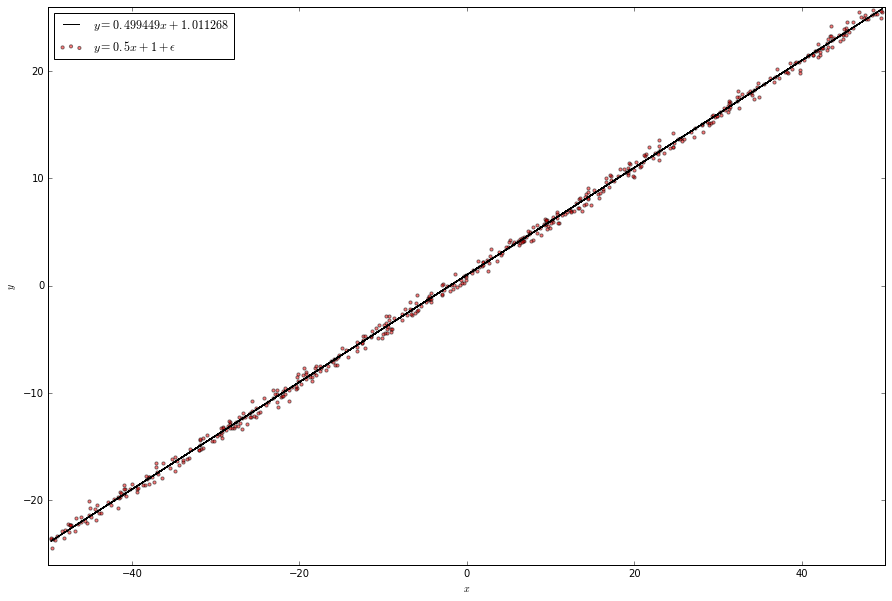

In [273]:
plt.figure(figsize=(15, 10))
plt.xlim((-50, 50))
plt.ylim((-26,26))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, k*x + b, c = 'black')
plt.scatter(x, y, s=10, c='r', alpha=0.5)
plt.legend(["$y = {:f} x + {:f}$".format(k, b), "$y = 0.5 x + 1 + \epsilon$"], loc='best')
plt.show()

Добавим новых точек.

In [274]:
x = np.append(x, stats.uniform(loc=-50, scale = 100).rvs(size=75))

In [275]:
y = np.append(y, -1 + stats.norm(loc=0, scale=(0.2) ** 0.5).rvs(size=75))

In [278]:
k, b = optimize.minimize(MSE, [0.0, 0.0]).x
print ("MSE\ny = kx + b\nk = {:f}, b = {:f}".format(k, b))

MSE
y = kx + b
k = 0.424155, b = 0.758342


In [280]:
k_mae, b_mae = optimize.minimize(MAE, [0.0, 0.0]).x
print ("MAE\ny = kx + b\nk = {:f}, b = {:f}".format(k_mae, b_mae))

MAE
y = kx + b
k = 0.496930, b = 0.994921


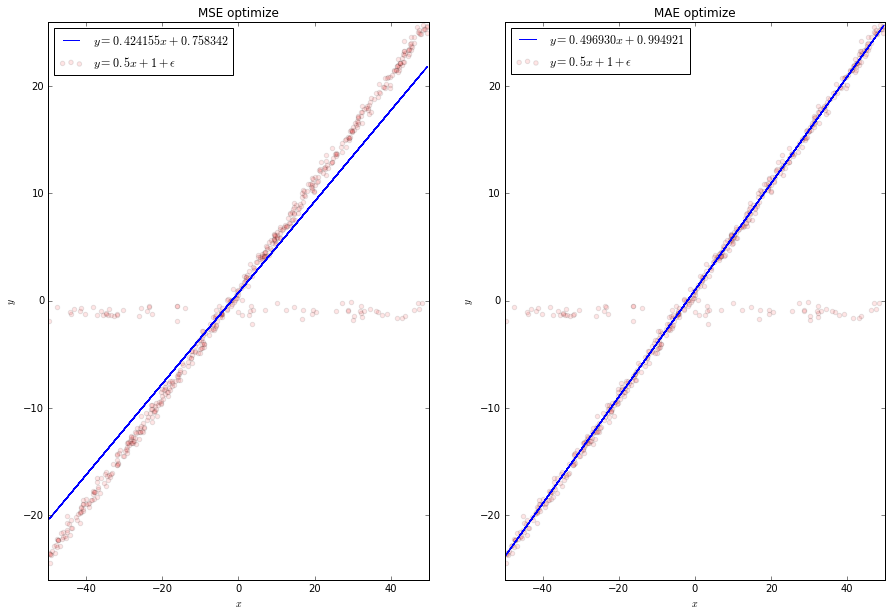

In [293]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.xlim((-50, 50))
plt.ylim((-26,26))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("MSE optimize")
plt.scatter(x, y, alpha=0.1, c='r')
plt.plot(x, k*x + b, c = 'b')
plt.legend(["$y = {:f} x + {:f}$".format(k, b), "$y = 0.5 x + 1 + \epsilon$"], loc='best')

plt.subplot(1,2,2)
plt.title("MAE optimize")
plt.xlim((-50, 50))
plt.ylim((-26,26))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(x, y, alpha=0.1, c='r')
plt.plot(x, k_mae * x + b_mae, c = 'b')
plt.legend(["$y = {:f} x + {:f}$".format(k_mae, b_mae), "$y = 0.5 x + 1 + \epsilon$"], loc='best')
plt.show()

***Выводы:*** <br>
Модель, оптимизирующая MSE, гораздо менее устойчива к выбросам, чем модель, оптимизирующая MAE. В принципе, это понятно, ведь разность между точкой, лежащей на прямой, которая получена на текущем шаге в моделе с MSE, и точкой-выбросом большая $\implies$ в квадрате она очень большая, а в MAE-модели эта разность не вносит такую сильную ошибку в алгоритм. Хочется сказать, давайте всегда использовать MAE, однако модуль недифференцируем, а это значит, что мы не можем использовать целый список оптимизирующих алгоритмов, к примеру, всеми любимый градиентный спуск.

### Теоретические задачи

***1.*** *Покажите, что если в наивном байесовском классификаторе классы имеют одинаковые априорные вероятности, а плотность распределения признаков в каждом классе имеет вид $P(x^{(k)} ~|~ y) = \frac {1} {\sqrt{2 \pi \sigma ^ {2}}} e^{-\frac{(x^{(k)}-\mu_{y_{k}})^{2}}{2 \sigma^2}}$, $x^{(k)}, k = 1,...,n$ - признаки объекта $x$, классификация сводится к отнесению объекта $x$ к классу $y$, центр которого $\mu_{y}$ ближе всего к $x$.* <br><br>
***Решение***
<br>
По определению наивного байесовского классификатора: <br>
$$a(x) = \underset{y}{\mathrm{argmax}}~P(y ~| ~x) = \underset{y}{\mathrm{argmax}} ~P(x ~| ~y) ~ P(y).$$
Заметим, что априорные вероятности одинаковы, поэтому на $\underset{y}{\mathrm{argmax}}$ этот множитель не повлияет. 
<br>
Тогда, 
$$\begin{equation*}
\underset{y}{\mathrm{argmax}} ~P(x ~| ~y) ~ P(y) = \underset{y}{\mathrm{argmax}} ~P(x ~| ~y) = \underset{y}{\mathrm{argmax}} 
  \prod_{i=1}^{\infty} P(x^{(k)}~|~y).
\end{equation*} $$
Избавимся от экспоненты, взяв логарифм.
$$\begin{equation*}\underset{y}{\mathrm{argmax}} 
  \prod_{i=1}^{\infty} P(x^{(k)}~|~y) = \underset{y}{\mathrm{argmax}} 
  \prod_{i=1}^{\infty} \ln{P(x^{(k)}~|~y)} = \underset{y}{\mathrm{argmax}} 
  (-(\frac{1}{2} \ln{(2\pi\sigma^{2})} + \sum^{n}_{k=1} \frac{(x^{(k)}-\mu_{y_{k}})^{2}}{2 \sigma^2})) = \underset{x}{\mathrm{argmin}} 
  (\frac{1}{2} \ln{(2\pi\sigma^{2})} + \sum^{n}_{k=1} \frac{(x^{(k)}-\mu_{y_{k}})^{2}}{2 \sigma^2}).
\end{equation*} $$ 
Первое слагаемое не влияет на значение аргминимума, константа в знаменателе тоже, тогда:
$$\begin{equation*}
\underset{y}{\mathrm{argmin}} 
  (\frac{1}{2} \ln{(2\pi\sigma^{2})} + \sum^{n}_{k=1} \frac{(x^{(k)}-\mu_{y_{k}})^{2}}{2 \sigma^2})
 = \underset{y}{\mathrm{argmin}} 
  (\sum^{n}_{k=1} (x^{(k)}-\mu_{y_{k}})^{2}).
\end{equation*} $$ А внутри скобок по определению есть расстояние до центра $\mu_{y}$. <br>
Получается, мы свели задачу к нахождения такого класса, центр которого ближе всех к нашему $x$. Ч.т.д.
<br><br><br>

***2.*** *Покажите, что  треугольный ROC-AUC  (см.лекцию 2) в случае, когда классификатор дает случайные ответы $a(x) = 1$ с вероятностью $p$ и $a(x) = 0$ с вероятностью $1-p$, будет в среднем равен 0.5, независимо от p и доли класса 1 в обучающей выборке.* <br><br><br>

***Решение***
Для начала определимся с крайними значениями нашего треугольника. При $TPR = 1$, т.е. все ответы - верные, $FPR = 1$ => точка (1, 1), при $TPR = 0$ (все ответы - неверные), аналогично точка (0,0). <br>
Посмотрим, что такое True Positives. Пусть 1 будет "yes", а 0 - "no". Тогда из определения и значений $a(x)$: $$TP = \sum^{}_{x \in 1} a(x).$$
Теперь $FP$. Аналогично рассуждая: $$FP = \sum^{}_{x \in 0} a(x).$$
Аналогично $TN$ и $FN$:
$$TN = \sum^{}_{x \in 0} (1 - a(x)), ~ FN = \sum^{}_{x\in 1} (1 - a(x)).$$
Посчитаем $TPR$. $$ TPR = \frac{TP}{TP + FN} = \frac{\sum^{}_{x \in 1} a(x)}{\sum^{}_{x \in 1} a(x) + \sum^{}_{x\in 1} (1 - a(x))} = \frac{\sum^{}_{x \in 1}a(x)}{|1|}.$$
Считаем $FPR$. $$ FPR = \frac{FP}{FP + TN} = \frac{\sum^{}_{x \in 0} a(x)}{\sum^{}_{x \in 0} a(x) +\sum^{}_{x \in 0} (1 - a(x)) } = \frac{\sum^{}_{x \in 0}a(x)}{|0|}.$$
<br>
Построим треугольник $T$ по трём точкам: (0, 0), (1, 1) и $(FPR, TPR)$. Под ним будет треугольник с площадью 0.5 (как половина квадрата со стороной 1).<br>
Пусть $S_{AUC}$ - area under the curve. Теперь $$\mathbf{E} ~S_{AUC} = \mathbf{E}~ S_{T} + \mathbf{E} ~{0.5}.$$
Найдём $\mathbf{E}~S_{T}$, для этого сначала найдём площадь этого треугольника. Мы знаем координаты всех точек, воспользуемся формулой
$$ S = \frac{1}{2} \vec{a} \times \vec{b} = \frac{1}{2} (0 - 1) (TPR-1) - \frac{1}{2}(FPR-1)(0-1) = -\frac{1}{2} TPR + \frac{1}{2} + \frac{1}{2} FPR - \frac{1}{2} = \frac{1}{2} (FPR - TPR).$$ <br>
$$\mathbf{E}~\frac{1}{2}(FPR-TPR) = \frac{1}{2} (\frac{\sum^{}_{x \in 0} \mathbf{E} ~a(x)}{|0|} - \frac{\sum^{}_{x \in 1}\mathbf{E} ~a(x)}{|1|}).$$ Тут уже $\mathbf{E} a(x)$ для всех слагаемых будет одинаковым, вынесем и сократим:
$$ \frac{1}{2} (\frac{\sum^{}_{x \in 0} \mathbf{E} ~a(x)}{|0|} - \frac{\sum^{}_{x \in 1}\mathbf{E} ~a(x)}{|1|}) =  \frac{1}{2} (\mathbf{E} ~a(x) - \mathbf{E} ~a(x)) = 0.$$
Итого: $$\mathbf{E} ~S_{AUC} = 0.5$$ <br><br><br><br>

***3.*** *Утверждается, что метод одного ближайшего соседа асимптотически (при условии, что максимальное по всем точкам выборки расстояние до ближайшего соседа стремится к нулю) имеет матожидание ошибки не более чем вдвое больше по сравнению с оптимальным байесовским классификатором (который это матожидание минимизирует).
Покажите это, рассмотрев задачу бинарной классификации. Достаточно рассмотреть вероятность ошибки на фиксированном объекте $x$, т.к. матожидание ошибок на выборке размера $V$ будет просто произведением $V$ на эту вероятность. Байесовский классификатор ошибается на объекте $x$ с вероятностью: $$E_{B} = \min\{P(1~|~x), ~P(0~|~x))\}.$$
Условные вероятности будем считать непрерывными функциями от $x \in \mathbb{R}^{m}$, чтобы иметь возможность делать предельные переходы. Метод ближайшего соседа ошибается с вероятностью:$$E_{N} = P(y \neq y_{n}).$$

Здесь $y$ - настоящий класс $x$, а $y_{n}$ - класс ближайшего соседа $x_n$ к объекту $x$ в предположении, что в обучающей выборке n объектов, равномерно заполняющих пространство.
Докажите исходное утверждение, выписав выражение для $E_{N}$ (принадлежность к классам 0 и 1 для объектов $x$ и $x_n$ считать независимыми событиями) и осуществив предельный переход по $n$.
<br><br><br>
***Решение***
Разложим $P(y \neq y_n)$ по формуле полной вероятности и испольуем независимость, перебирая варианты $y$, $y_{n}$:
$$P(y \neq y_{n}) = \sum^{}_{y \neq y_n} P(y, y_n ~|~ x, x_n) = P(y = 0~|~x, x_n) P(y_n = 1~|~x, x_n) + P(y = 1~|~x, x_n)  P(y_n = 0~|~x, x_n) =^{y || x_n ~~ y_n || x}= P(y = 0~|~x) P(y_n = 1~|~x_n) + P(y = 1~|~x)  P(y_n = 0~|~ x_n) = P(0~|~x) P(1~|~x_n) + P(1~|~x) P(0~|~x_n) \leq 2 \min {(P(0~|~x) P (1~|~x))}\max {(P(0~|~x) P (1~|~x))}.$$
<br>
Заметим, что максимум меньше или равен единицы и получим нужное:
$$ 2 \min {(P(0~|~x) P (1~|~x))}\max {(P(0~|~x) P (1~|~x))} \leq 2 \min {(P(0~|~x) P (1~|~x))}$$